# Chapter 9 - Basic structure and error assumption diagnostics

Joshua French

To open this information in an interactive Colab notebook, click or scan the QR code below.

<a href="https://colab.research.google.com/github/jfrench/LinearRegression/blob/master/notebooks/09-basic-structure-and-error-assumption-diagnostics-notebook.ipynb"> <img src="https://raw.githubusercontent.com/jfrench/LinearRegression/23b6bb9f948afab5075d92556502a31665bac25b/images/qr-structure-error-diagnostics.svg"> </a>

------------------------------------------------------------------------

In [ ]:
if(!require(faraway, quietly = TRUE)) {
  install.packages("faraway",
                   repos = "https://cran.rstudio.com/")
}
if(!require(KingCountyHouses, quietly = TRUE)) {
  install.packages("KingCountyHouses",
                   repos = "https://cran.rstudio.com/")
}
if(!require(car, quietly = TRUE)) {
  install.packages("car",
                   repos = "https://cran.rstudio.com/")
  library(car)
}
if(!require(lmtest, quietly = TRUE)) {
  install.packages("lmtest",
                   repos = "https://cran.rstudio.com/")
  library(lmtest)
}

We adjust some printing options for clarity.

In [ ]:
options(digits = 7, scipen = 2)

We discuss basic but effective approaches for assessing the validity of several of the assumptions discussed in the previous notebook.

We will focus on assessing assumptions related to:

-   Model structure.
-   The distribution of the errors.

These assumptions tend to be checked in similar ways.

# Illustration data sets

To facilitate our discussion we will consider two main data sets.

## The `prostate` data set

The first data set we will consider is the `prostate` data set, which is available in the **faraway** R package. The data set provides information about 97 men who were going to receive a radical prostatectomy.

The `prostate` data set is a data frame with 97 rows and 9 columns. The **faraway** package provides the following descriptions of the variables:

-   `lcavol`: log(cancer volume).
-   `lweight`: log(prostate weight).
-   `age`: age in years.
-   `lbph`: log(benign prostatic hyperplasia amount).
-   `svi`: seminal vesicle invasion.
-   `lcp`: log(capsular penetration).
-   `gleason`: Gleason score.
-   `pgg45`: percentage Gleason scores 4 or 5.
-   `lpsa`: log(prostate specific antigen).

We load this data set.

In [ ]:
data(prostate, package = "faraway")

The `svi` variable is a factor, so we convert it to a factor with appropriate levels.

In [ ]:
prostate$svi <- factor(prostate$svi, labels = c("non-invasive", "invasive"))

## The `home_prices` data set

We will also use the `home_prices` data set from the **KingCountyHouses** package.

The `home_prices` data set contains the sales prices of homes sold in King County, WA between 2014-05-02 and 2015-05-27. The data set is a data frame (tibble) with 21,613 rows and 19 columns. A subset of the relevant variables includes:

-   `date_sold`: date of sale (`date`).
-   `price`: sale price (log10 units, `numeric`).
-   `bedrooms`: number of bedrooms (`numeric`).
-   `bathrooms`: number of bathrooms (`numeric`).
-   `sqft_living`: size of living space (`numeric`).
-   `sqft_lot`: size of property (`numeric`).
-   `floors`: number of floors (`numeric`).
-   `waterfront`: indicator variable for a waterfront view.
-   `view`: a numeric rating of the quality of the home’s view (`numeric`).
-   `condition`: a factor variable indicating the condition of the house (poor to very good, `factor`).
-   `sqft_above`: size of living space above ground (`numeric`).
-   `sqft_basement` :size of living space below ground (`numeric`).
-   `yr_built`: year the home was built (`numeric`).
-   `year_renovated`: the year renovated and, if not renovated, the year built (`numeric`).
-   `zip_code`: the zip code of the home (`factor`).

We load the data below.

In [ ]:
data(home_prices, package = "KingCountyHouses")

We do not wish to work with all of the variables for practical reasons, so we keep only the first 13 variables of the data frame.

In [ ]:
home_prices <- home_prices[, 1:13]

We will also remove the `sqft_basement` variable because the `sqrt_above` and `sqft_basement` variables sum to equal `sqft_living`, so we will have an issue with collinearity if we don’t remove one of the variables.

In [ ]:
home_prices <- home_prices[, -12]

Lastly, we remove the `date_sold` variable from `home_prices` since it isn’t in a particularly useful format to use as a regressor in our model.

In [ ]:
home_prices <- home_prices[, -1]

## Initial fitted models

The validity of our assumptions depends on the model fit to the data.

For the prostate data we will regress `lpsa` on all the remaining variables in the `prostate` data frame.

-   A shortcut for fitting this model is the formula `y ~ .`, where `y` is the response and `.` indicates that all other variables in the data frame should be included as regressors.

In [ ]:
lmod_prostate <- lm(lpsa ~ ., data = prostate)
coef(lmod_prostate)

Similarly, for the `home_prices` data set, we will regress the `price` variable on all of the remaining variables in `home_prices`.

In [ ]:
lmod_homes <- lm(price ~ ., data = home_prices)
coef(lmod_homes)

# Checking structure

As mentioned in the previous chapter, the most important assumption we make for our linear models is that the model structure is correct.

Technically, this assumption is impossible to verify.

Instead, we verify that the model does an adequate job of approximating the behavior of the observed data.

If the model is unable to mimick the behavior of the observed data, then the correct model structure assumption is violated.

## Residual plot

The most basic approach for assessing whether the structural assumption is satisfied uses a plot of the residuals versus fitted values.

This assumption is satisfied (technically, not violated) if the residuals appear to be randomly and symmetrically scattered around a horizontal line running through 0 on the y-axis.

This assumption is violated if the residuals appear to have a mean different from zero for certain fitted values because one of our assumptions is that the errors have mean 0 for any combination of regressors.

-   A violation will often appear as a systematic trend or curve in the residual plot.
-   In general, this assumption is violated if the residuals have streaks of mostly positive or negative values for continuous subsets of the fitted values.

Consider the residual plot below.

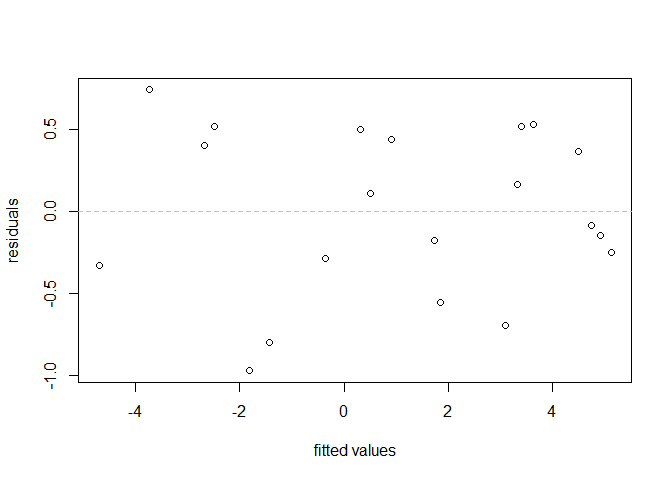

The residual plot above is consistent with a correct model structure.

-   The residuals are randomly scattered and symmetric around the horizontal line running through the y-axis at 0.
-   A moving average of the residuals appears to be close to 0 as we move from left to right along the x-axis.

A different residual plot is shown below.

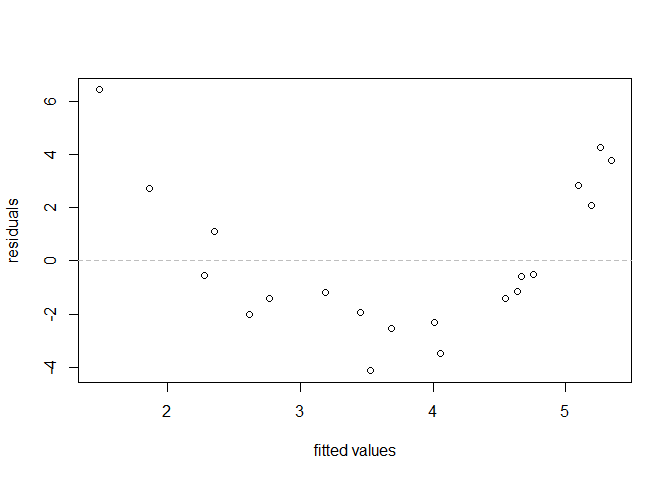

The plot above shows evidence of a structural problem.

-   The data systematically curve as we move from left to right along the x-axis.
-   The mean of the residuals is clearly positive when the fitted values are less than 2.5, negative between 2.5 and 5.75, and positive for fitted values greater than 5.75.
-   In this second example, we are missing a needed quadratic regressor in our model.

## Intuition behind the residual plot

Why does the residual plot approach work for assessing a structural problem in our fitted model?

-   We assume that the errors have mean zero for any combination of our predictors.
-   If our fitted model adequately captures the mean of the data, then the residuals will have the same property. We proved this in the Basic Theoretical Results notebook.
-   We expect our residuals to randomly fluctuate above and below 0 with no systematic pattern related to a specific combination of regressors (and specific combinations of regressors are used to determine the fitted values).

Assessing whether the structure of the model is correct is difficult to separate from assessing the validity of the assumption that the mean of the errors is zero.

-   If the errors didn’t have mean zero but the model was correct, then our regression model would be non-identifiable because we wouldn’t be able to separate the mean of the errors from the mean of the other components of the model.
-   This is why we assume the mean of the errors is zero.

A related approach for assessing the validity of the structural assumption is to examine plots of the residuals versus each predictor.

-   The structural assumption isn’t violated as long as the residuals appear to be randomly and symmetrically scattered around a horizontal line running through 0 on the y-axis .

## Structural check for `prostate` data

We examine a plot of the residuals versus fitted values for the model we fit to the `prostate` data.

The `residualPlot` function in the **car** package is a convenient way of producing a plot of the residuals versus fitted values for a fitted model.

The `residualPlot` function is a complex function, so we set `quadratic = FALSE` to get a simple plot.

In [ ]:
residualPlot(lmod_prostate, quadratic = FALSE)

The points appear to be randomly scattered above and below 0 as we move from left to right across the x-axis. There is no clear violate of the structural assumption.

The `residualsPlots` function in the **car** package will produce plots of the residuals versus each first-order predictor and the fitted values.

-   Setting `tests = FALSE` and `quadratic = FALSE` simplifies the output produced by the function.
-   Setting `fitted = FALSE` prevents the function from displaying a plot of the residuals versus fitted values.

We examine the residual plots for the model fit to the `prostate` data below. Because there would be 9 plots by default, we select only 4 of the predictors to simplify our display.

In [ ]:
residualPlots(lmod_prostate, 
              terms = ~ lcavol + age + svi + gleason,
              tests = FALSE, quadratic = FALSE, fitted = FALSE,
              smooth = TRUE)

The residual plots associated with `lcavol` and `age` look relatively symmetric around 0 with no clear patterns.

For a categorical predictor like `svi`, we want the box plot of the residuals to be symmetric around zero, which is what we see for this data. There is no evidence of a structural problem.

Looking at the residual plot for the `gleason` predictor, the residual values tend to be lower for larger values of `gleason`.

-   There are relatively few observations with high `gleason` values, so it is difficult to draw a definitive conclusion. This is not clear evidence of a structural problem.
-   This may be something to explore further.

## Structural check for `home_prices` data

We now examine a plot of the residuals versus fitted values for the `home_prices` data.

In [ ]:
residualPlot(lmod_homes, quadratic = FALSE)

There are many more points in this plot compared to the residual plot for the `prostate` data, making it more difficult to assess this assumption.

The bulk of the data between the fitted values 5.25 and 6.25 is approximately symmetric around zero (as far as we can tell).

There is one unusual point in the upper left part of the plot.

-   This is an **outlier**.
-   Since this is only a single unusual point in a data set with many observations, this is not something to be concerned about.

However, the residuals begin to systematically fall below 0 when the fitted values are above 6.25.

-   This is an indication that we have a structural deficiency in our fitted model that should be addressed.

# Checking constant variance

Another key assumption is that the variance of the errors is constant for all combinations of regressor values.

Similar to the check of structure, we can check this assumption through residual plots.

However, it is important to note that even if the errors have constant variance, the residuals do not.

Even if the variance of the errors is constant,

$$\mathrm{var}(\hat{\epsilon}_i \mid \mathbf{X}) = \sigma^2(1-h_i), \quad i = 1,2,\ldots,n,$$

where $h_i=\mathbf{H}_{i,i}$ is $i$th diagonal element of the hat matrix $\mathbf{H}=\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T$.

-   $h_1, h_2, \ldots, h_n$ are known as the set of **leverage** or **hat values**.

It is recommended that instead of assessing the validity of this assumption with the ordinary residuals, $\hat{\epsilon}_1, \ldots, \hat{\epsilon}_n$, we instead use the **standardized residuals** given by the equation

$$r_i = \frac{\hat{\epsilon}_i}{\hat{\sigma}\sqrt{1-h_i}}, \quad i=1,2,\ldots,n.$$

Under the standard assumptions, the standardized residuals have mean 0 and variance 1.

## Standardized residual plot

The constant error variance assumption can be assessed using plots of the standardized residuals versus the fitted values or predictors.

-   If the constant error variance assumption is satisfied, then the points of these plots should have constant thickness, symmetric about 0 as we move from left to right along the x-axis.

Consider the 4 plots below:

-   Panel (a) shows data that perfectly satisfy this assumption. However, the plot itself doesn’t have perfect constant thickness as we move from left to right along the x-axis.
-   Panel (b) shows data with increasing variability as we move from left to right across the x-axis. This is difficult to see in the plot because the variability increases but then appears to decease.
-   Panel (c) shows data that has slightly decreasing variability as we move from left to right along the x-axis. However, this is difficult to see in the plot..
-   Panel (d) shows data that has a structural issue (notice the curve in the data compared to the 0-line) while the points also increase in variability as we move from left to right along the x-axis.

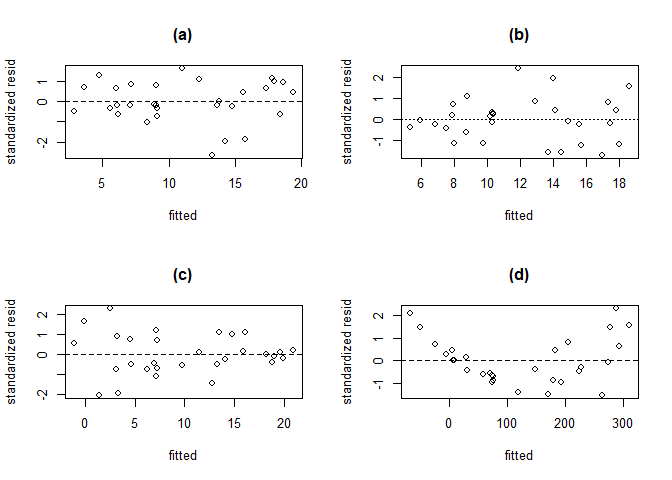

The examples in the graphic above show that our plots can be inconclusive or difficult to interpret, even when the constant error variance assumption is technically satisfied (Panel (a)) or violated (Panels (b) and (c)).

What should we do if the standardized residual plots are inconclusive for testing the constant error variance assumption?

-   We don’t conclude an assumption is violated unless the violation is clear.
-   Try to use a different method.

## Scale-location plot

A scale-location plot can be used to assess whether the error variance is constant when the standardized residual plot is inconclusive AND the structural assumption doesn’t appear to be violated.

A **scale-location** plot is a plot of $\sqrt{|\hat{\boldsymbol{\epsilon}}|}$) versus $\hat{\mathbf{y}}$, i.e., a plot of the square root of the absolute value of the residuals versus the fitted values.

-   If the constant error variance assumption is satisfied (i.e., not clearly violated), then the points of this plot should should have constant thickness as we move from left to right along the x-axis.

Recall that in panel (c) of the previous plot, we thought there was a slight decrease in the variability of the residuals as we moved from left-to-right across the x-axis.

We produce a scale-location plot for the data in panel (c) of the plot above. That scale-location plot is shown below.

-   The red line is a visual indication of how the variability changes from left to right and should be approximately flat if this assumption is not violated.
-   The red line goes down from left-to-right in our plot, which indicates a violation of the constant error variance assumption.

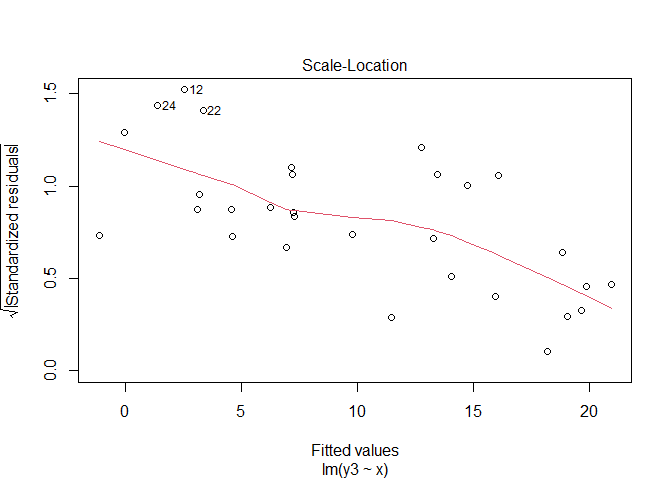

## Constant variance check for `prostate` data

We now assess the validity of the constant error variance assumption for the `prostate` data.

The `residualPlot` function from the **car** package can be used to construct a plot of the standardized residuals versus the fitted values.

-   Set `type = "rstandard"`.

We produce a standardized residual plot for the model fitted to the `prostate` data.

In [ ]:
residualPlot(lmod_prostate, type = "rstandard", quadratic = FALSE)

The plot of the standardized residuals versus the fitted values has almost perfectly constant thickness as we move from left to right along the x-axis, so there is no indication of a non-constant error variance issue for our fitted model.

We can produce plots of the standardized residuals versus the predictors using the `residualPlots` function.

-   We must specify `type == "rstandard"`.

There is no indication of a violation of the constant error variance assumption in the plots below.

In [ ]:
residualPlots(lmod_prostate, type = "rstandard",
              terms = ~ lcavol + age + svi + pgg45,
              tests = FALSE, quadratic = FALSE, fitted = FALSE)

## Constant variance check for `home_prices` data

We now assess the validity of the constant error variance assumption for the `home_prices` data.

Our standardized residual plot seems to show clear evidence that the variability tends to decrease as we move from left to right along the x-axis.

In [ ]:
residualPlot(lmod_homes, type = "rstandard", quadratic = FALSE)

The verify our belief, we can look at a scale-location plot for the fitted model

The `plot` function can be used to produce a scale-location plot.

-   The `plot` function has a method for `lm` objects.
-   Setting the `which` argument to 3 will produce a scale-location plot.

We produce a scale-location plot of the fitted model for `home_prices`.

In [ ]:
plot(lmod_homes, which = 3)

The red line shows that the variability decreases as we move from left to right. It then appears to increase, but this is an artifact of the model having a structural deficiency for larger fitted values.

Focusing on the fitted values less than 6.25, we do see the absolute value of the standardized residuals tend to decrease as we move from left to right.

# Checking normality

A key assumption of many of our hypothesis tests and confidence intervals is that the errors are normally distributed.

We have previously shown our residuals are normal if the errors are normal.

-   Our residuals also have mean 0 if the errors have mean zero.

## The Q-q plot

To assess whether the assumption of normally-distributed errors is reasonable, we will visually compare the residuals to the quantiles we would expect to get from the same number of i.i.d. normally-distributed observations with mean 0 and variance 1.

-   This plot is called a quantile-quantile or **q-q plot**.
-   If the normality assumption is satisfied, then a a plot of the observed values compared to the theoretical quantiles will fall approximately in a straight line.

The `qqnorm` function can be used to create a q-q plot of data we believe to come from a normal distribution.

We can add a reference line to our q-q plot using the `qqline` function to see how closely the points fall to a straight line.

We provide a q-q plot example below when the data are independent, identically-distributed (i.i.d.) normal normal random variables with a mean of 0 and a variance of 1.

In [ ]:
set.seed(19)
e <- rnorm(30)
qqnorm(e)
qqline(e)

The points of the q-q plot fall fairly close to a straight line, which is what we expect when the sample observations are a i.i.d. sample from a normal distribution.

There tends to be more variability in the tails of a q-q plot (i.e., for the smallest and largest quantiles) so those points tend to fall a little farther from a straight line.

Observations that deviate substantially from normality will result in a q-q plot that doesn’t look like a straight line of points.

Consider a q-q plot of data sampled from a chi-square distribution with 5 degrees of freedom.

-   This distribution is positively skewed.
-   The points of the q-q plot are curved and do not follow an approximately straight line.

In [ ]:
set.seed(22)
e2 <- rchisq(30, 5)
qqnorm(e2)
qqline(e2)

Q-q plots are generally constructed under the assumption that the data are independent and identically distributed.

-   Ordinary residuals do not have constant variance.
-   We should scale the residuals to have constant variance prior to constructing a q-q plot.
-   Though the residuals are not independent, the correlation is typically weak and can be ignored when constructing a q-q plot.

The **standardized residuals** are one form of scaled residuals with variance equal to 1.

The **studentized residuals** are another form of scaled residuals with variance of 1.

-   The denominator used to scale the studentized residuals uses a different estimate of the error variance, $\sigma^2$, than the standardized residuals. We do not discuss those details here.
-   The studentized residuals should be have a $t$ distribution with $n-p-1$ degrees of freedom under the standard assumptions, assuming our model has $p$ estimated regression coefficients.

Standardized or studentized residuals should be used to assess the normality assumption.

The `qqPlot` function in the **car** packages produces q-q plots of the *studentized* residuals along with confidence intervals that quantify how much variability in the residuals is expected with a specified confidence level.

## The Shapiro-Wilk test

Another approach to assess normality is the Shapiro-Wilk test (Shapiro and Wilk 1965).

The null hypothesis for this test is that the data are a random sample from a normal distribution.

The alternative hypothesis is that the data are not a random sample from a normal distribution.

The test statistic is a complicated function of order statistics, and is not directly needed for our purposes, so we do not provide its formula.

If the p-value of the Shapiro-Wilk test is less then the specified significance level, then we conclude that the data are not a random sample from a normal distribution.

Otherwise, we fail to reject the null hypothesis that the data are a random sample from a normal distribution.

The Shapiro-Wilk test can be applied to a vector of data using the `shapiro.test` function.

## Normality check for `prostate` data

We now use the `qqPlot` function to create a q-q plot of the studentized residuals for the model fitted to the prostate data.

In [ ]:
qqPlot(lmod_prostate)

The points of the q-q plot fall close to a straight line, so the assumption of normally-distributed errors appears to be reasonable assumption for the fitted model.

The `qqPlot` function also produces pointwise 95% confidence envelopes for the quantiles, giving us an idea of how much the points can deviate from a straight line without the assumption being violated.

-   The envelopes are pointwise, which means they don’t adjust for multiple comparisons.

To help confirm our belief, we apply the Shapiro-Wilk test to the standardized residuals of our fitted model.

-   We use the `rstandard` function to extract the standardized residuals from our fitted model.

In [ ]:
shapiro.test(rstandard(lmod_prostate))

Since our p-value is large, we believe our residuals (and by proxy, our errors) are a sample from a normal distribution.

## Normality check for `home_prices` data

We start with a q-q plot of the studentized residuals of the fitted model for the `home_prices` data.

In [ ]:
qqPlot(lmod_homes)

There are so many points in our plot that it is difficult to assess the central part of the plot. However, it is clear that the tails of the q-q plot deviate from a straight line.

-   The normal error assumption appears to be violated for our fitted model.

We could confirm our beliefs using the Shapiro-Wilk test, but the R function takes a maximum of 5000 observations, and we have over 20,000 residuals.

Even though the normal error assumption appears to be violated for our fitted model, this may not be an issue in practice.

-   The Central Limit Theorem applies to our estimated coefficients, so our confidence interval and hypothesis test procedures should still be approximately valid.
-   Our prediction intervals are very sensitive to the normality assumption, so that type of inference should not be trusted when the normal error assumption is violated.

# Checking for correlated errors

Our errors are supposed to be uncorrelated.

This assumption is impractical to check unless our data are time series or longitudinal data (observations observed over a series of time) or spatial data (the observations are associated with a specific geographic location).

We will learn how to assess this assumption for time series data.

If the data are not time series or spatial data then we don’t need to bother checking this assumption.

If the errors, $\boldsymbol\epsilon$, are uncorrelated, then the residuals, $\hat{\boldsymbol\epsilon}$, are typically close to uncorrelated.

Conversely, if the residuals are highly correlated, then it is unlikely that the errors are uncorrelated.

We will use the residuals as a proxy to assess whether the errors are temporally correlated.

We will illustrate checking this assumption using the monthly total of international airline passengers in thousands from 1949 to 1960, which is a classic data set provided by Box and Gwilym M Jenkins (1994).

-   The data are available in the `AirPassengers` data set in the **datasets** package.

We first convert the data to a more usable form for our purposes. We will let month 1 be January of 1949 and month 144 be December of 1960 (the 12th month of the 12th year)

In [ ]:
air <- data.frame(month = 1:144, passengers = c(AirPassengers))

We begin by creating a scatter plot of the passenger totals versus the month.

In [ ]:
plot(passengers ~ month, data = air)

The passenger totals are clearly increasing over time and also increasing in variability.

We take the `log` of `passengers` to correct for the increasing variability of that variable over time.

-   The transformed data have more constant variance over time.

In [ ]:
plot(log(passengers) ~ month, data = air)

We will regress `log(passengers)` on `month` and then discuss diagnostics to assess whether the residuals are temporally correlated.

In [ ]:
lmod_air <- lm(log(passengers) ~ month, data = air)

## Residuals versus time plot

The easiest way to check for temporally correlated residuals in time series data is to plot the residuals sequentially over time.

-   If the residuals tend to cluster with sequences of positive or negative residuals, then the data have a positive temporal correlation.

We create a scatter plot of the residuals versus month for the model fit to the passengers data.

-   We add a horizontal reference line at $y = 0$.

In [ ]:
plot(residuals(lmod_air) ~ month, data = air, ylab = "residuals")
abline(0, 0)

The pattern is difficult to identify because there are so many points in our plot.

If we focus on the first 24 months of data, we can clearly see sequences of times where the residuals are almost all positive or almost all negative.

-   The residuals appear to have a positive temporal correlation.

In [ ]:
plot(residuals(lmod_air) ~ month, data = air,
     ylab = "residuals", xlim = c(0, 24))
abline(0, 0)

## Successive residual pairs plot

A better way to assess whether there is strong temporal correlation in the residuals is to plot pairs of successive residuals versus each other, i.e., to plot $\hat{\epsilon}_{i+1}$ versus $\hat{\epsilon}_i$ for $i=1,2,\ldots,n-1$.

-   This is a scatter plot of the pairs $(\hat{\epsilon}_i, \hat{\epsilon}_{i+1})$ for $i=1,2,\ldots,n-1$.
-   If the successive residuals show a positive trend then there is positive temporal correlation in the residuals.
-   If the successive residuals show a negative trend then there is negative temporal correlation in the residuals.
    -   Negative correlation is very difficult to see visually when looking at a plot of the residuals over time because the pattern will look random.
-   If the successive residuals appear to be a random scatter around 0, then there is no evidence of temporal correlation in the residuals.

To construct a plot of successive residual pairs we can use the following code.

In [ ]:
n <- nobs(lmod_air)
ehat <- residuals(lmod_air)
plot(ehat[2:n] ~ ehat[1:(n-1)],
     xlab = expression(hat(epsilon)[i]),
     ylab =expression(hat(epsilon)[i+1]))
abline(h = 0 , v = 0, col = "grey")

`ehat[2:n]` extracts the last $n-1$ residuals while `ehat[1:(n-1)]` extracts the first $n-1$ residuals.

The remaining code adds horizontal and vertical reference lines at $y=0$ and $x=0$, respectively.

Since the successive residual pairs plot has a positive trend, there is clear evidence of positive temporal correlation among the residuals (and by proxy, the errors).

If either of the previous plots do not provide a satisfactory conclusion, then we can use the Durbin-Watson test to draw a definitive conclusion.

## The Durbin-Watson test

The **Durbin-Watson test** Durbin and Watson (1951) is a formal test for assessing whether the residuals are temporally correlated.

Let $\rho$ denote the temporal correlation for a “population of residuals”.

-   Our observed residuals are treated as a random sample from that population.

The null hypothesis of the Durbin-Watson test is $$
H_0: \text{The residuals are uncorrelated over time}, \rho = 0.
$$ The alternative hypothesis of the Durbin-Watson test is $$
H_a: \text{The residuals are correlated over time in some way}, (\rho \neq 0, \rho > 0, \text{ or }\rho < 0).
$$

The test statistic for the Durbin-Watson test relies on comparing successive residuals and is given by the expression $$
DW = \frac{\sum_{i=2}^n(\hat{\epsilon}_i - \hat{\epsilon}_{i-1})^2}{\sum_{i=1}^n \hat{\epsilon}_i^2}.
$$

If we apply the Durbin-Watson test to our residuals and get a small p-value then it indicates that the residuals have a significant temporal correlation across time.

The `dwtest` function in the **lmtest** package can be used to apply the Durbin-Watson test to a fitted model.

-   The first argument is a fitted `lm` object.
-   The `alternative` argument can be changed to perform an upper-tailed test ($\rho > 0$, `alternative = "greater"`), a two-tailed test ($\rho \neq 0$, `alternative = "two.sided"`), or lower-tailed test ($\rho < 0$, `alternative = "less"`).

We perform an upper-tailed Durbin-Watson test on the model we fit to the airline passengers data.

In [ ]:
dwtest(lmod_air, alternative = "greater")

The p-value for this test is close to 0, so we conclude that there is positive temporal correlation among the residuals over time.

# Summary of Methods for Checking Error Assumptions

**Structural assumption**

-   Plot of residuals versus fitted values.
-   Plot of residuals versus each predictor.
    -   For both plots, if this assumption is satisfied, the residuals should be symmetrically and randomly scattered around a horizontal line at $y=0$ as we move from left to right along the x-axis.
    -   If the mean of the residuals appears to differ from zero as we move from left to right along the x-axis, then the structural assumption is violated.

**Constant error variance assumption**

-   Plot of standardized residuals versus fitted values.
-   Plot of standardized residuals versus each predictor.
    -   For both plots, if this assumption is satisfied, then the points should have constant thickness around a horizontal line at $y=0$ as we move from left to right along the x-axis.
-   Plot of $\sqrt{| \hat{\epsilon} |}$ versus fitted values.
    -   Only use this check if the structural assumption appears to be satisfied.
    -   If this assumption is satisfied, then the points of the plot should have constant thickness as we move from left to right along the x-axis.

**Normal error assumption**

-   Q-q plot of standardized or studentized residuals.
    -   The points should follow approximately a straight line if the data are consistent with normally-distributed errors.
-   Shapiro-Wilk test.
    -   If the p-value is large, then the residuals are consistent with a random sample coming from a normal distribution.
    -   If the p-value is small, then the residuals are not consistent with being a random sample from a normal distribution, and the assumption of normal errors appears to be violated.

**Uncorrelated errors**

This only needs to be checked for time series/longitudinal data or geographically-referenced data.

For assessing temporal correlation:

-   Plot of residuals versus time.
    -   The plot should be a random scatter of points with no clear pattern if the residuals aren’t (positively) correlated over time.
    -   If there are sequences where there are many positive residuals or many negative residuals, then this assumption is violated, and the residuals exhibit positive temporal correlation.
-   Plot of successive residuals pairs.
    -   A positive trend indicates positive temporal correlation among our residuals.
    -   A negative trend indicates negative temporal correlation among our residuals.
    -   A random scatter indicates the residuals are consistent with being uncorrelated over time.
-   Durbin-Watson test applied to the residuals.
    -   A large p-value indicates the residuals are compatible with being uncorrelated over time.
    -   A small p-value indicates the residuals are temporally correlated, with the type of correlation detected being consistent with the alternative hypothesis used for the test.

# References

Box, George E P, and Gregory C Reinsel Gwilym M Jenkins. 1994. *Time Series Analysis: Forecasting and Control, 3rd Edition*. Holden-Day: San Francisco.

Durbin, J., and G. S. Watson. 1950. “Testing for Serial Correlation in Least Squares Regression. i.” *Biometrika* 37 (3/4): 409–28. <https://doi.org/10.1093/biomet/37.3-4.409>.

———. 1951. “Testing for Serial Correlation in Least Squares Regression. II.” *Biometrika* 38 (1-2): 159–78. <https://doi.org/10.1093/biomet/38.1-2.159>.

Shapiro, S. S., and M. B. Wilk. 1965. “An Analysis of Variance Test for Normality (Complete Samples)†.” *Biometrika* 52 (3-4): 591–611. <https://doi.org/10.1093/biomet/52.3-4.591>.